# Homework - Neural networks - Part D (20 points)
## Predicting similarity ratings with a deep convolutional network

by *Brenden Lake* and *Todd Gureckis*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
This homework is due before midnight on Monday, Feb. 13, 2023.
</div>



**Summary:** We will examine whether deep convolutional neural networks (convnets) trained for image classification can predict human similarity ratings for handwritten digits. The images below are all clear examples of the digit '8'. Nonetheless, the left two '8's look more "similar" to me than the right two '8's. Can a neural network trained for classification help to explain judgments such as this one?

In this notebook, we will use a pre-trained convnet for digit recognition to predict similarity judgments. We will then test the network's predictions by collecting similarity ratings from a couple of friends. *This assignment requires collecting a small amount of behavioral data, so grab a friend and don't wait to the last minute to get started!*

|High similarity&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|Low similarity&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:------|:------|
|<img src="images/pair2.png" width=150px>|<img src="images/pair1.png" width=150px>|


## Background

The goal of this assignment is to give you some hands-on experience with a powerful toolkit for computer vision (deep convnets), which has also recently been applied for studying human perception and categorization.

In 2012, Krizhevsky, Sutskever, and Hinton trained a deep convnet (now called 'AlexNet') for object recognition and achieved very impressive results, reducing the number of errors on ImageNet by almost half compared to the next best approach. This paper ignited the recent deep learning revolution in computer vision, although convnets were being used for this purpose long before (LeCun et al. (1989) was the first to train deep convnets for digit recognition).

Recently, the success of convnets has led researchers in cognitive science and neuroscience to explore their potential applications for understanding human visual perception and categorization. Here are some examples: Yamins et al. (2014) showed that deep convnets can predict neural response in high-level visual areas; Lake, Zaremba, Fergus, and Gureckis (2015) showed that deep convnets can explain human typicality ratings for some classes of natural images; Peterson, Abbott, and Griffiths (2016) explored convents for predicting similarity ratings between images.

In this assignment, like Peterson et al., we will explore convnets for predicting human similarity judgments between images. We use a relatively small-scale network trained for digit recognition, but the same principles can be used to study much more complex deep convnets trained for object recognition. Although "similarity" can be a tricky construct in cognitive science (Medin, Goldstone, & Gentner, 1993), similarity judgments are still a useful tool in a cognitive scientist's toolbox for understanding representation.

**References:**
* Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. In Advances in Neural Information Processing Systems.
* Lake, B. M., Zaremba, W., Fergus, R., & Gureckis, T. M. (2015). Deep Neural Networks Predict Category Typicality Ratings for Images. In Proceedings of the Cognitive Science Society.
* LeCun, Y., Boser, B., Denker, J. S., Henderson, D., Howard, R. E., Hubbard, W., & Jackel, L. D. (1989). Backpropagation applied to handwritten zip code recognition. Neural Computation, 1(4), 541-551.
* Medin, D. L., Goldstone, R. L., & Gentner, D. (1993). Respects for similarity. Psychological Review, 100(2), 254.
* Peterson, J. C., Abbott, J. T., & Griffiths, T. L. (2016). Adapting deep network features to capture psychological representations. arXiv preprint arXiv:1608.02164.
* Yamins, D. L., Hong, H., Cadieu, C. F., Solomon, E. A., Seibert, D., & DiCarlo, J. J. (2014). Performance-optimized hierarchical models predict neural responses in higher visual cortex. Proceedings of the National Academy of Sciences, 111(23), 8619-8624.

## Downloading MNIST

MNIST is one of the most famous data sets in machine learning. It is a digit recognition task, where the goal is classify images of handwritten digits with right label, e.g, either '0','1','2', ... '9'. The training set consists of 60,000 images (6,000 per digit), and the test set of has 10,000 additional images.

Execute the code below to load some libraries and the MNIST "test set." We will not need the training set, since we will use a pre-trained network for this assignment.

In [2]:
!pip install torchvision

In [3]:
!pip install --upgrade pip

In [4]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import os
import numpy as np
from scipy.spatial.distance import cosine
import random

print('Loading MNIST')
test_loader = torch.utils.data.DataLoader(datasets.MNIST('~/shared',
                                                            train=False,
                                                            download=True,
                                                            transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Normalize((0.1307,), (0.3081,))])
                                                        ),batch_size=1000, shuffle=True)
print('MNIST has been loaded.')

Loading MNIST
MNIST has been loaded.


## Convnet architecture for digit recognition
Here is the `Net` class defining the network we are using for digit recognition.

**First convolutional layer:**  
This layer takes an image (28x28 for MNIST) and applies a bank of learnable 5x5 filters to produce 10 new images (also known as channels or feature maps). Each feature map is passed through a non-linearity (a rectified linear unit or "ReLU"). Last, there is a max pooling operation that reduces the size of each feature map by half.

**Second convolutional layer:**  
This layer takes the feature maps from the previous layer, applies a bank of learnable 5x5 filters, and produces 20 new feature maps. Again, ReLU's are applied as well as max pooling.

**Fully-connected layer:**  
Next is a standard fully-connected layer of 50 units. At this stage, the entire image is summarized with a vector of size 50. ReLu's are used again.

**Output layer:**
The output layer has 10 units with one to represent each of the 10 digits. It uses a softmax activation function, to ensure the network's predictions are a valid probability distribution of the 10 possibilities.

Execute the code to define the `Net` class.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 10 channels in first convolution layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 20 channels in second conv. layer
        self.fc1 = nn.Linear(320, 50) # 50 hidden units in first fully-connected layer
        self.fc2 = nn.Linear(50, 10) # 10 output units

    def forward(self, x):

        # first convolutional layer
        h_conv1 = self.conv1(x)
        h_conv1 = F.relu(h_conv1)
        h_conv1_pool = F.max_pool2d(h_conv1, 2)

        # second convolutional layer
        h_conv2 = self.conv2(h_conv1_pool)
        h_conv2 = F.relu(h_conv2)
        h_conv2_pool = F.max_pool2d(h_conv2, 2)

        # fully-connected layer
        h_fc1 = h_conv2_pool.view(-1, 320)
        h_fc1 = self.fc1(h_fc1)
        h_fc1 = F.relu(h_fc1)
        
        # classifier output
        output = self.fc2(h_fc1)
        output = F.log_softmax(output,dim=1)
        return output, h_fc1, h_conv2, h_conv1


## Evaluating classification performance of the network

Here we will execute our first bit of non-trivial code. To save time, we already trained a the MNIST network for you. The code below loads the pre-trained model. If you are curious, it only takes a couple minutes to train a MNIST model from scratch on a standard laptop, and we used a version of the PyTorch code from [here](https://github.com/pytorch/examples/tree/master/mnist) to train this network.

After loading the network, the function `test_all` iterates through the whole test set and computes the network's predicted class for each image. It outputs the percent correct.

The function `test_viz` picks a few images from the test set at random and displays them along with the network's predicted class labels.

Execute the code below. If everything is working right, **you should get test performance of 98.71%** correct which isn't state-of-the-art, but is reasonable. You can also see some of the network's specific predictions on some test images, which should also look good. You can re-run to see a few different sets of test images.

Convnet has been loaded successfully.
Running through the test set...
 Accuracy on the test set is 98.71 percent correct!

Here are some predictions from the network.
The images are shown below their predicted class labels.


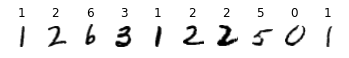

In [6]:
# Evaluate classification accuracy on the entire MNIST test set
def test_all():
    correct = 0
    for data, target in test_loader:
        # run the data through the network
        output, h_fc1, h_conv2, h_conv1 = model(data)
        # compare prediction to ground truth
        pred = torch.max(output,dim=1)[1] # get the index of the max log-probability
        correct += torch.eq(pred,target.view_as(pred)).cpu().sum().item()
    perc_correct = 100. * correct / len(test_loader.dataset)
    return perc_correct

# Show the network's predicted class for an arbitrary set of `nshow` images from the MNIST test set
def test_viz(nshow=10):
    
    # grab a random subset of the data
    testiter = iter(test_loader)
    images, target = next(testiter)
    perm = np.random.permutation(images.shape[0])
    data = images[perm[:nshow]]
    
    # get predictions from the network
    output, h_fc1, h_conv2, h_conv1 = model(data)
    pred = torch.max(output,dim=1)[1]
    pred = pred.numpy().flatten()
    
    # plot predictions along with the images
    for i in range(nshow):
        ax = plt.subplot(1, nshow, i+1)
        imshow(utils.make_grid(data[i]))
        plt.title(str(pred[i]))

# Display an image from the MNIST data set
def imshow(img):
    img = 1 - (img * 0.3081 + 0.1307) # invert image pre-processing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

checkpoint = torch.load('models/convnet_mnist_pretrained.pt')
model = Net()
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print('Convnet has been loaded successfully.')
print('Running through the test set...')
test_acc = test_all()
print(' Accuracy on the test set is %.2f percent correct!' % test_acc)
print("")
print("Here are some predictions from the network.")
print("The images are shown below their predicted class labels.")
test_viz()

## Selecting digits for similarity analysis

Here are two more useful functions: `get_random_subset` and `plot_image_pairs.`

As mentioned, we are looking at within-class similarity comparisons (e.g., comparing two different images of the digit '8'). The function `get_random_subset` generates a set of random images pairs from a particular image class `digit_select` from the MNIST test set. The number of random pairs can be set by `npairs`. 

The other function is `plot_image_pairs` which visualizes each of the random image pairs. The pairs are input as two list of image tensors, where images with the same index are paired.

In [7]:
def get_random_subset(digit_select, npairs=20):
    # digit_select: which digit do we want to get images for?
    testiter = iter(test_loader)
    images, target = next(testiter)
    indices = np.flatnonzero(target.numpy() == digit_select)    
    np.random.shuffle(indices)
    indx1 = torch.tensor(indices[:npairs],dtype=torch.long)
    indx2 = torch.tensor(indices[npairs:npairs*2],dtype=torch.long)
    images1 = images[indx1]
    images2 = images[indx2]
    plt.figure(1,figsize=(4,40))
    plot_image_pairs(images1,images2)
    return images1, images2

def plot_image_pairs(images1,images2,scores_net=[],scores_people=[]):
    # images1 : list of images (each image is a tensor)
    # images2 : list of images (each image is a tensor)
    # scores_net (optional) : network similarity score for each pair
    # scores_people (optional) : human similarity score for each pair
    npairs = images1.size()[0]
    assert images2.size()[0] == npairs
    for i in range(npairs):
        ax = plt.subplot(npairs, 1, i+1)
        imshow(utils.make_grid([images1[i], images2[i]]))
        mytitle = ''
        if len(scores_net)>0:
            mytitle += 'net %.2f, ' % scores_net[i] 
        if len(scores_people)>0:
            mytitle += 'human. %.2f' % scores_people[i]
        if mytitle:
            plt.title(mytitle)

Here is code for sampling 20 random pairings of images of the digit '8' (or whichever digit you set `digit_select` to). Run to sample the pairings and then visualize them (you may have to scroll). 

<div class="alert alert-info">
To save or print out the image pairs, which will be helpful later in the assignment, you can right click and save the output as an image.
</div>

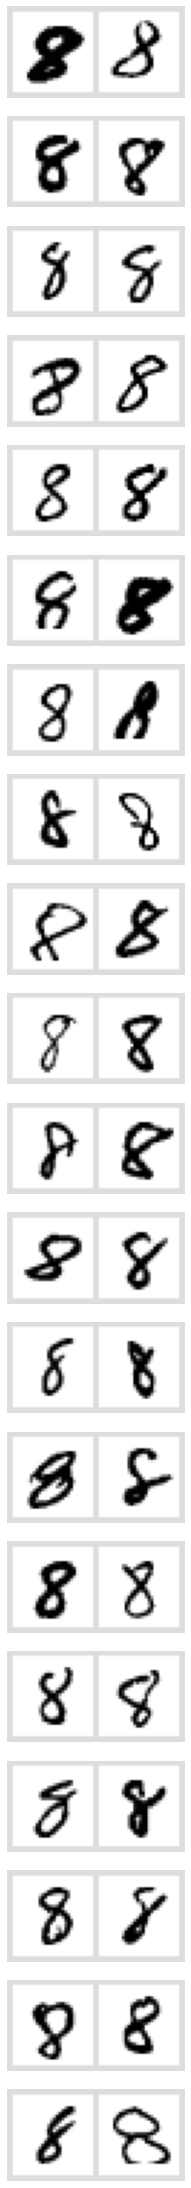

In [8]:
images1_digit8,images2_digit8 = get_random_subset(digit_select=8, npairs = 20)

## Computing similarity judgments with the network
To get predictions out of the network, we take the hidden representation at a particular layer as a representation of an image. The hidden representation computes high-level features of the images, which we will use to compare the images. To compute the similarity between two images, we get the two hidden vectors and compare them with the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) metric. Cosine similarity measures the angle between two vectors, which can be an effective way of measuring similarity between patterns of activation on the hidden layer.

The function `get_sim_judgments` takes two lists of images and computes the similarity between each pair. Using the `layer` parameter, you can choose between the fully connected layer (`fc`), first convolutional layer (`conv1`), or second convolutional layer (`conv2`).

The function `normalize` rescales a vector to have a minimum value of 0 and maximum value of 1.

In [10]:
# re-scale a vector to have a minimum value of 0, maximum of 1
def normalize(v):
    # v : numpy vector
    v = v - v.min()
    v = v / v.max()
    return v

# Compute convnet similarity for each pair of images
def get_sim_judgments(images1,images2,layer='fc'):
    # images1 : list of N images (each image is a tensor)
    # images2 : list of N images (each image is a tensor)
    # layer : which layer do we want to use? fully connected ('fc'), 
    #         first convolutional ('conv1'), or second convolutional ('conv2')
    #
    # Return
    #  v_sim : N-dimensional vector
    N = images1.size()[0] # number of pairs
    assert N == images2.size()[0]
    output_1, h_fc1_1, h_conv2_1, h_conv1_1 = model(images1)
    output_2, h_fc1_2, h_conv2_2, h_conv1_2 = model(images2)
    
    # grab the tensors from the appropriate layer
    if layer=='fc':
        T1 = h_fc1_1
        T2 = h_fc1_2
    elif layer=='conv1':
        T1 = h_conv1_1
        T2 = h_conv1_2
    elif layer=='conv2':
        T1 = h_conv2_1
        T2 = h_conv2_2
    else:
        raise Exception('Layer parameter has unrecognized value')
    
    # flatten the tensors for each image
    T1 = T1.detach().numpy().reshape(N,-1)
    T2 = T2.detach().numpy().reshape(N,-1)

    v_sim = np.zeros(N)
    for i in range(N): # for each pair
        v1 = T1[i,:]
        v2 = T2[i,:]
        v_sim[i] = 1-cosine(v1,v2) # using cosine distance 
    return v_sim

# Get similarity bsaed on the fully conneted layer at the end
v_sim_net_digit8 = get_sim_judgments(images1_digit8,images2_digit8,'fc')
print("Similarity ratings from the neural network the for digit 8:")
print(v_sim_net_digit8)

Similarity ratings from the neural network the for digit 8:
[0.80846733 0.83052403 0.86038691 0.79485697 0.93561971 0.80146188
 0.72476238 0.66464961 0.74497366 0.92458856 0.80752867 0.88360792
 0.79806012 0.64726126 0.88403058 0.74933422 0.77568662 0.79700416
 0.54028654 0.6942839 ]


<div class="alert alert-success">
<h2> Problem 1 (10 points) </h2>
<br>
Go through the following steps for the digit '8':
<ol>
<li> *Get judgments from the network.* Run all of the code above to sample a list of 20 pairs of images for that digit. For each pair, get a measure of the network's similarity between the images as measured on the fully-connected `fc` layer. (You may have already done all of this.)</li><br>
<li>*Get judgments from people.* Ask two people to rate the same image pairs on a 1 (least similar) to 10 (most similar) scale, using the question "How similar do these two images look to you?" (You can right-click and save the jupyter notebook figures as images). Ask your participant (in a socially distanced way) to rate each pair. Enter the ratings in the arrays `ratings_human_1_digit8` and `ratings_human_2_digit8` below. One participant can be yourself, but the other should be someone else.</li><br>
<li>*Compare.* Run the code below to compute the correlation coefficient and scatter plot.</li>
</ol>
</div>

Correlation between net and human similarity ratings: r =
0.587


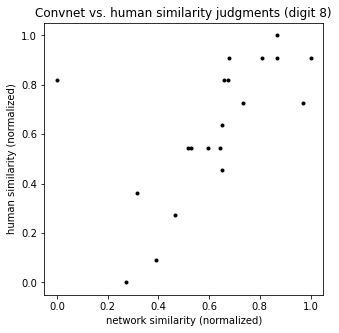

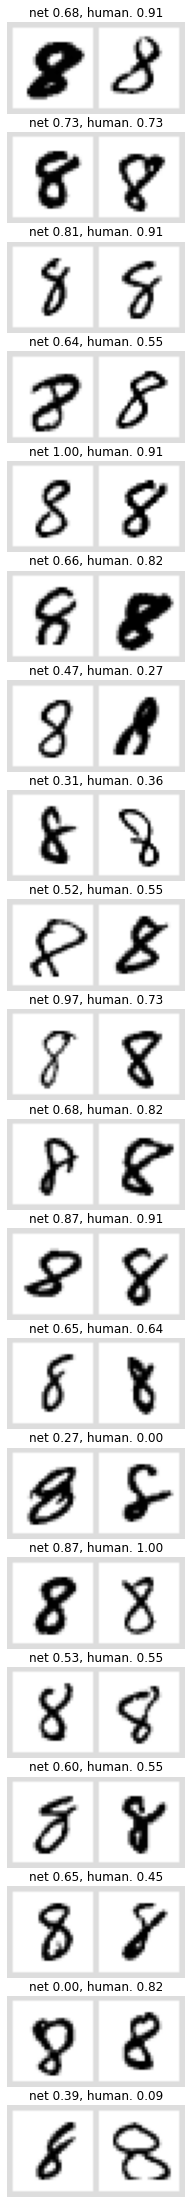

In [11]:
# YOUR PARTICIPANT RATINGS GO HERE
ratings_human_1_digit8 = np.array([5,6,7,6,7,7,4,4,5,4,7,7,6,2,6,5,6,6,7,3], dtype='float')
ratings_human_2_digit8 = np.array([8,5,6,3,6,5,2,3,4,7,5,6,4,1,8,4,3,2,5,1], dtype='float')

# Analysis code
ratings_human_mean_digit8 = (ratings_human_1_digit8 + ratings_human_2_digit8)/2

v_sim_net_norm = normalize(v_sim_net_digit8)
v_sim_human_norm = normalize(ratings_human_mean_digit8)

print("Correlation between net and human similarity ratings: r ="),
print(round(np.corrcoef(v_sim_net_norm,v_sim_human_norm)[0][1],3))

# Scatter plot
plt.figure(1,figsize=(5,5))
plt.plot(v_sim_net_norm,v_sim_human_norm,'k.')
plt.xlabel('network similarity (normalized)')
plt.ylabel('human similarity (normalized)')
plt.title('Convnet vs. human similarity judgments (digit 8)')
plt.show()

# pairs with similarity ratings
plt.figure(2,figsize=(4,40))
plot_image_pairs(images1_digit8,images2_digit8,v_sim_net_norm,v_sim_human_norm)
plt.show()

<div class="alert alert-success">
<h2> Problem 2 (10 points) </h2>
<br>
How well does the convolutional neural network do at predicting the similarity ratings? What is it capturing? What is it not capturing? (Keep your answer brief. About 5 sentences is good.)
</div>

<div class="alert alert-info">
Don't worry if your fit isn't very good! A convnet is very far from a perfect account of human similarity ratings. I had reasonable success with the `8` digit but I wouldn't except a correlation higher than r=0.6. This assignment is not graded on how good the fit is.
</div>

**My solution:**
Although the convNet is able to reach 98.71% accuracy, when it comes to similarity check for numbers within the same class, it still cannot compare to human eyes. It learns the general pattern for 8 which allows it to predict the class labels correctly, but when it comes to detect detailed differences, it is not able to perform well. Take the last two pairs as examples, two human ratings consider the second to last as similar but the net considers it as very unsimilar whereas it considers the last pair much more similar than the human ratings do. 